# Standard Includes

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

# Login to Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Datasets

## 2D Uniform Gaussian

In [0]:
class Gaussian2D(torch.utils.data.Dataset):
    def __init__(self, size, dim = 2):
        # Load Data 
        self.x_train = np.random.random_sample((size, dim))
        
        self.y_train = np.ones((size, 1))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# GAN Setup

## Hyper parameter setup

In [0]:
hyperparam = {
  # Device configuration
  "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),

  "latent_size" : 8,
  "hidden_size" : 32,
  "data_dim" : 2,
  "num_epochs" : 10000,
  "batch_size" : 10,
  "lr" : 0.0002
}

## Architecture

In [0]:
# Discriminator
D = nn.Sequential(
    nn.Linear(hyperparam["data_dim"], hyperparam["hidden_size"]),
    nn.LeakyReLU(0.2),
    nn.Linear(hyperparam["hidden_size"], hyperparam["hidden_size"]),
    nn.LeakyReLU(0.2),
    nn.Linear(hyperparam["hidden_size"], 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(hyperparam["latent_size"], hyperparam["hidden_size"]),
    nn.ReLU(),
    nn.Linear(hyperparam["hidden_size"], hyperparam["hidden_size"]),
    nn.ReLU(),
    nn.Linear(hyperparam["hidden_size"], hyperparam["data_dim"]),
    nn.Tanh())

# Device setting
D = D.to(hyperparam["device"])
G = G.to(hyperparam["device"])

## Loss and Optimization

In [0]:
opt = {
  # Binary cross entropy loss
  "criterion" : nn.BCELoss(),
  "d_optimizer" : torch.optim.Adam(D.parameters(), lr=hyperparam["lr"]),
  "g_optimizer" : torch.optim.Adam(G.parameters(), lr=hyperparam["lr"])
}

# Helper function
def reset_grad(opt):
    opt["d_optimizer"].zero_grad()
    opt["g_optimizer"].zero_grad()

# Training

In [0]:
def train_gan(data_loader, D, G, hyperparam, opt):  
    g_loss_list = []
    e = [] # epoch list
    d_loss_real_list = []
    d_loss_fake_list = []
    total_step = len(data_loader)

    for epoch in range(hyperparam["num_epochs"]):
        e.append(epoch)
        for i, (data_point, _) in enumerate(data_loader):
            #data_point = data_point.reshape(hyperparam["batch_size"], -1).to(hyperparam["device"])
            data_point = data_point.to(hyperparam["device"])
            # Create the labels which are later used as input for the BCE loss
            real_labels = torch.ones(hyperparam["batch_size"], 1).to(hyperparam["device"])
            fake_labels = torch.zeros(hyperparam["batch_size"], 1).to(hyperparam["device"])

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(data_point.float())
            
            d_loss_real = opt["criterion"](outputs, real_labels)
            if i == total_step - 1:
                d_loss_real_list.append(d_loss_real)
            real_score = outputs
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = torch.randn(hyperparam["batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            if i == total_step - 1:
                d_loss_fake_list.append(d_loss_fake)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad(opt)
            d_loss.backward()
            opt["d_optimizer"].step()
            
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            # Compute loss with fake images
            z = torch.randn(hyperparam["batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])

            fake_images = G(z)
            outputs = D(fake_images)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = opt["criterion"](outputs, real_labels)
            if i == total_step - 1:
                g_loss_list.append(g_loss)

            # Backprop and optimize
            reset_grad(opt)
            g_loss.backward()
            opt["g_optimizer"].step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                      .format(epoch, hyperparam["num_epochs"], i+1, total_step, d_loss.item(), g_loss.item(), 
                              real_score.mean().item(), fake_score.mean().item()))
        
        
            # Print State of the GAN
            '''if epoch % 10000 == 0:
                print("The current data point is {}".format(data_point))
                print("The current prediction is {}".format(fake_images))'''

        if epoch % 100 == 0:
            plt.plot(e, d_loss_real_list, 'b-', label = 'd_loss_real')
            plt.plot(e, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
            plt.plot(e, g_loss_list, 'r-', label = 'g_loss')
            plt.legend()
            plt.show()

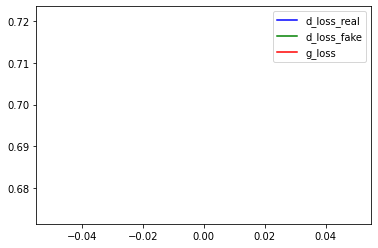

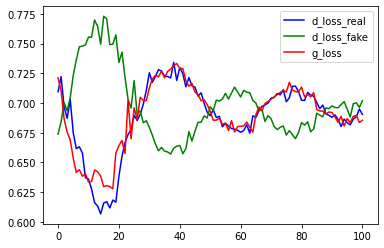

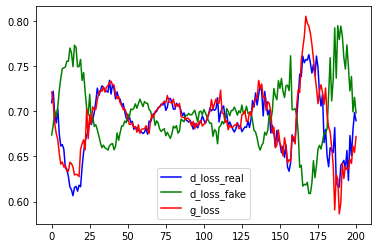

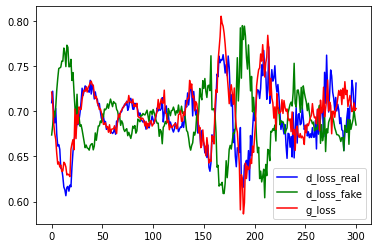

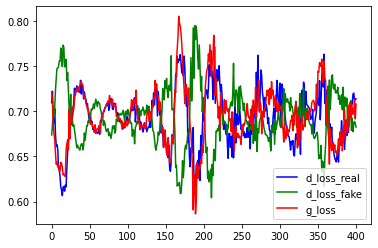

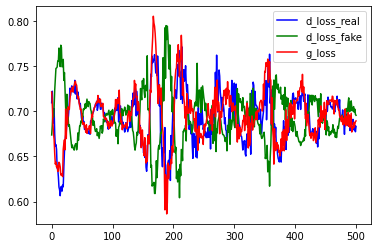

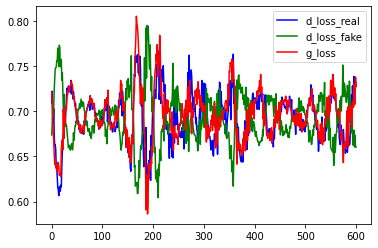

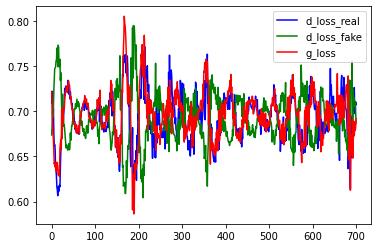

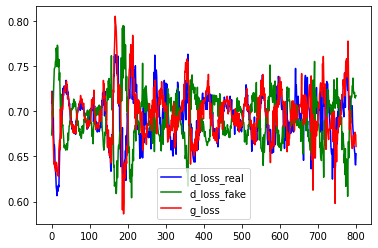

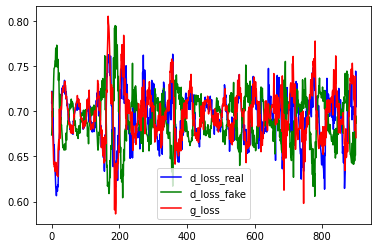

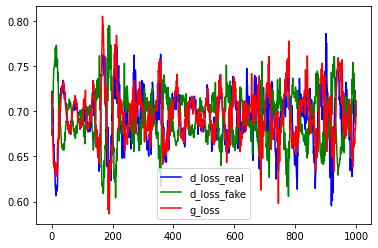

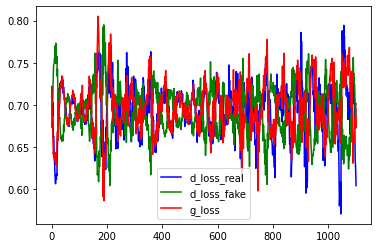

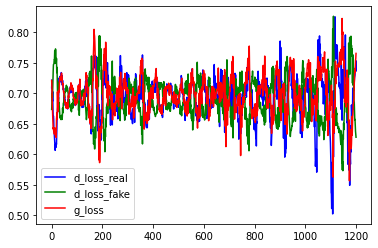

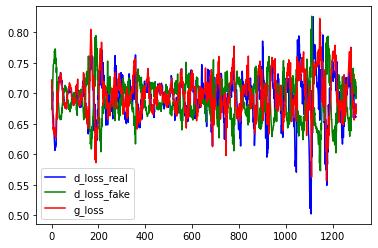

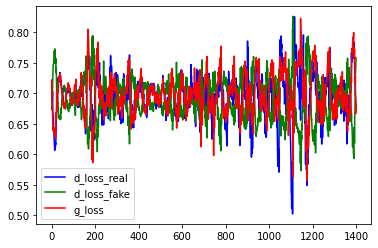

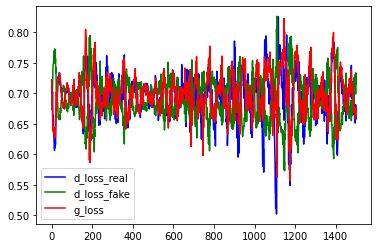

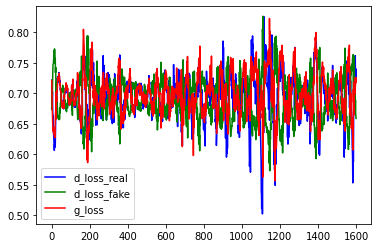

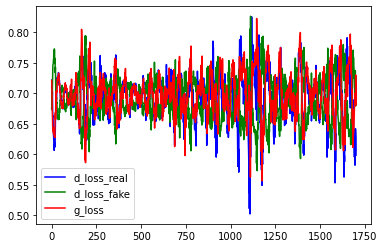

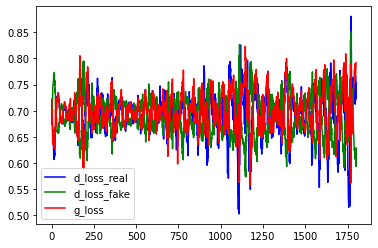

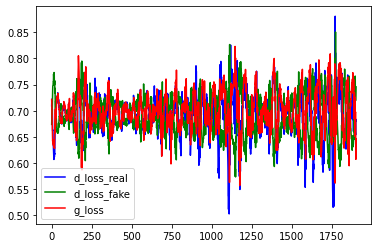

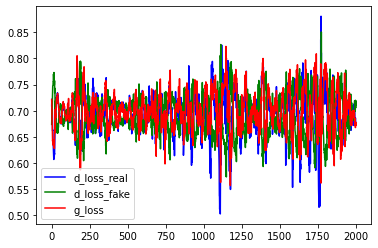

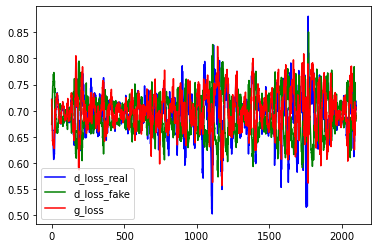

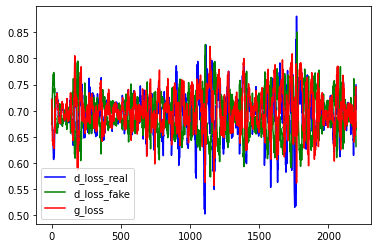

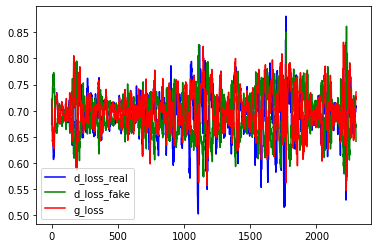

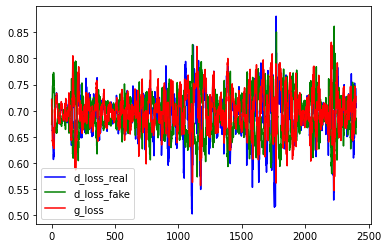

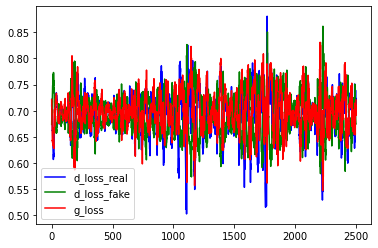

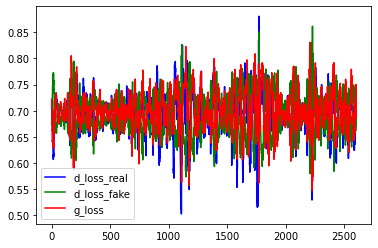

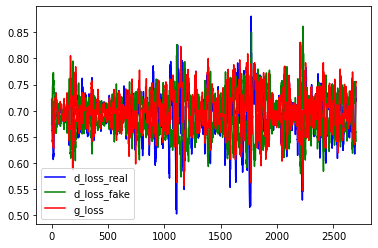

KeyboardInterrupt: ignored

In [48]:
ds = Gaussian2D(100, 2)
data_loader = torch.utils.data.DataLoader(dataset=ds,
                                           batch_size=hyperparam["batch_size"], 
                                           shuffle=True)
train_gan(data_loader, D, G, hyperparam, opt)